In [56]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [57]:

path = "./market_data/"

# Filtrar solo los archivos que terminan en .csv
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

# Leer cada CSV en un DataFrame y guardarlo en un diccionario
dfs = {fname.replace(".csv", ""): pd.read_csv(os.path.join(path, fname)) for fname in csv_files}


In [58]:
dfs.keys()

dict_keys(['AL30_1205_CI_PESOS', 'dlr_may_1205', 'PESOS-1305', 'AL30_1205_CI_CCL', 'AL30_1205_CI_MEP'])

In [59]:
df_al30ci = dfs['AL30_1205_CI_PESOS']
df_al30ci["fecha"] = df_al30ci["fecha_nano"].apply(lambda x: datetime.datetime.utcfromtimestamp(x*1e-9))


/tmp/ipykernel_88978/3485365850.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df_al30ci["fecha"] = df_al30ci["fecha_nano"].apply(lambda x: datetime.datetime.utcfromtimestamp(x*1e-9))


In [60]:
df_al30ci["side"].value_counts()

side
OF       1309080
BI        940321
TRADE     153901
Name: count, dtype: int64

In [61]:
import numpy as np
import pandas as pd

def build_df_for_side(df, curr_side):
    # Filtrar por side
    df_side = df[df["side"] == curr_side]
    if df_side.empty:
        return pd.DataFrame(columns=["fecha_nano", "prices", "quantities", "side"])

    # Arrays
    f = df_side["fecha_nano"].to_numpy(dtype=np.int64)
    p = df_side["price"].to_numpy(dtype=np.int32)
    q = df_side["quantity"].to_numpy(dtype=np.int32)

    # Orden estable por fecha
    order = np.argsort(f, kind="mergesort")
    f_s, p_s, q_s = f[order], p[order], q[order]

    # Agrupar por timestamp
    keys, idx, cnt = np.unique(f_s, return_index=True, return_counts=True)
    starts, ends = idx, idx + cnt

    # Construir filas
    rows = []
    for s, e, k in zip(starts, ends, keys):
        seg_p = p_s[s:e]
        seg_q = q_s[s:e]
        rows.append({
            "fecha_nano": int(k),
            "prices": seg_p[seg_p > 0].tolist(),
            "quantities": seg_q[seg_q > 0].tolist(),
            "side": curr_side
        })

    return pd.DataFrame(rows)

# Descubrir los sides presentes (p. ej. ["BI", "OF", "TRADE"])
sides_presentes = df_al30ci["side"].dropna().unique().tolist()

# Construir un dict con un DF por side
dfs_por_side = {}
for curr_side in sides_presentes:
    dfs_por_side[curr_side] = build_df_for_side(df_al30ci, curr_side)

# Concat final (mismo esquema que antes + columna 'side')
df_concat = pd.concat(dfs_por_side.values(), ignore_index=True)



In [62]:
dfs_por_side["OF"]

,fecha_nano,prices,quantities,side
0,1747058117512618279,[81900],[3000],OF
1,1747058210293570287,"[79440, 81900]","[133223, 3000]",OF
2,1747058214463031494,"[79440, 81000]","[133223, 663]",OF
3,1747058226743689670,"[79440, 81000]","[143223, 663]",OF
4,1747058290708782688,"[79440, 80400, 81000]","[143223, 266620, 663]",OF
...,...,...,...,...
265763,1747078219158102591,"[77720, 77780, 77800]","[11808, 2647, 556]",OF
265764,1747078219158320313,"[77720, 77780, 77800, 77840]","[11808, 2647, 556, 148]",OF
265765,1747078219158557609,"[77720, 77780, 77800, 77840, 77950]","[11808, 2647, 556, 148, 200000]",OF
265766,1747078426428358492,"[77720, 77780, 77800, 77840]","[11808, 2647, 556, 148]",OF


In [63]:
import pandas as pd
import numpy as np

def build_metrics(df):
    def _row_metrics(row):
        prices = np.asarray(row["prices"], dtype=float)
        qtys = np.asarray(row["quantities"], dtype=float)
        if qtys.size == 0 or np.nansum(qtys) == 0:
            return pd.Series({"vwap": np.nan, "spread": np.nan})
        vwap = np.average(prices, weights=qtys)
        var = np.average((prices - vwap) ** 2, weights=qtys)
        return pd.Series({"vwap": vwap, "spread": np.sqrt(var)})

    metrics = df.apply(_row_metrics, axis=1)
    return pd.concat([df[["fecha_nano", "side"]].reset_index(drop=True), metrics], axis=1)

df_metrics = build_metrics(df_concat)

In [64]:
df_metrics

,fecha_nano,side,vwap,spread
0,1747058117512618279,OF,81900.000000,0.000000
1,1747058210293570287,OF,79494.175873,361.023023
2,1747058214463031494,OF,79447.725080,109.505467
3,1747058226743689670,OF,79447.188191,105.649928
4,1747058290708782688,OF,80066.030996,458.897225
...,...,...,...,...
611728,1747078010499753898,TRADE,77720.000000,0.000000
611729,1747078016425763650,TRADE,77720.000000,0.000000
611730,1747078016459180789,TRADE,77720.000000,0.000000
611731,1747078019463413165,TRADE,77720.000000,0.000000


In [65]:
import pandas as pd

df_metrics = df_metrics.sort_values("fecha_nano").reset_index(drop=True)

def add_time_deltas(df, col="fecha_nano"):
    df = df.copy()
    delta_ns = df[col].diff()  # diferencia entre filas consecutivas

    df["delta_ns"] = delta_ns
    df["delta_us"] = delta_ns / 1e3   # microsegundos
    df["delta_ms"] = delta_ns / 1e6   # milisegundos
    df["delta_s"]  = delta_ns / 1e9   # segundos

    # tiempo relativo desde el primer timestamp
    first_ts = df[col].iloc[0]
    df["t_rel_ms"] = (df[col] - first_ts) / 1e6

    return df

df_metrics = add_time_deltas(df_metrics)
df_metrics = df_metrics[df_metrics["t_rel_ms"] > 4e5]


## Elegimos una ventana

Side=TRADE: 50 puntos en ventana [1000000.000, 1005000.000] ms
Side=BI: 80 puntos en ventana [1000000.000, 1005000.000] ms
Side=OF: 93 puntos en ventana [1000000.000, 1005000.000] ms


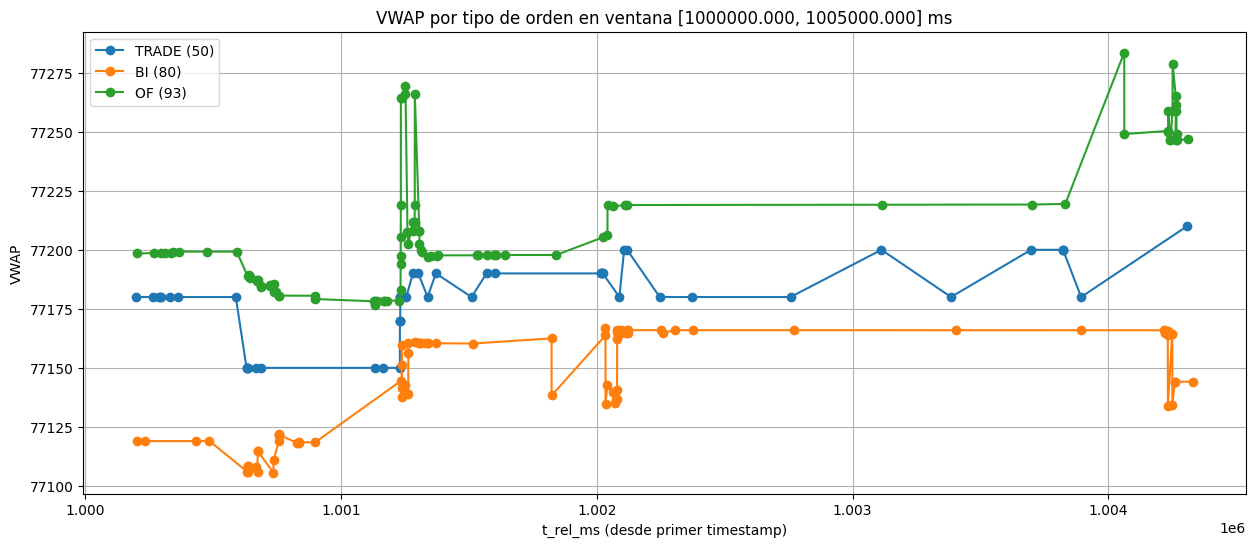

,fecha_nano,side,vwap,spread,delta_ns,delta_us,delta_ms,delta_s,t_rel_ms
21520,1747059117710992687,TRADE,77180.000000,0.000000,303310450.0,303310.450,303.310450,0.303310,1.000198e+06
21521,1747059117713828118,BI,77119.021940,20.417003,2835431.0,2835.431,2.835431,0.002835,1.000201e+06
21522,1747059117713987140,OF,77198.437034,18.857808,159022.0,159.022,0.159022,0.000159,1.000201e+06
21523,1747059117746052884,BI,77118.964492,21.006636,32065744.0,32065.744,32.065744,0.032066,1.000233e+06
21524,1747059117776755801,TRADE,77180.000000,0.000000,30702917.0,30702.917,30.702917,0.030703,1.000264e+06
...,...,...,...,...,...,...,...,...,...
21738,1747059121779747626,OF,77248.836727,35.756213,1305110.0,1305.110,1.305110,0.001305,1.004267e+06
21739,1747059121780198944,OF,77246.574866,33.149861,451318.0,451.318,0.451318,0.000451,1.004268e+06
21740,1747059121820710881,TRADE,77210.000000,0.000000,40511937.0,40511.937,40.511937,0.040512,1.004308e+06
21741,1747059121824651857,OF,77246.734947,33.133706,3940976.0,3940.976,3.940976,0.003941,1.004312e+06


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def select_time_window_by_time(df, t_start_ms=None, t_end_ms=None, window_ms=None, time_col="t_rel_ms"):
    if len(df) == 0:
        return df.copy(), (np.nan, np.nan)

    df_sorted = df.sort_values(time_col).reset_index(drop=True)
    t_min, t_max = df_sorted[time_col].iloc[0], df_sorted[time_col].iloc[-1]

    if t_start_ms is not None and window_ms is not None:
        t_start, t_end = t_start_ms, t_start_ms + window_ms
    elif t_end_ms is not None and window_ms is not None:
        t_start, t_end = t_end_ms - window_ms, t_end_ms
    elif t_start_ms is not None and t_end_ms is not None:
        t_start, t_end = t_start_ms, t_end_ms
    else:
        raise ValueError("Especificá (t_start_ms y window_ms) o (t_end_ms y window_ms) o (t_start_ms y t_end_ms).")

    if t_start > t_end:
        t_start, t_end = t_end, t_start
    t_start = max(t_min, t_start)
    t_end   = min(t_max, t_end)

    mask = (df[time_col] >= t_start) & (df[time_col] <= t_end)
    return df.loc[mask].copy(), (t_start, t_end)

def plot_vwap_window_time(df_metrics, t_start_ms=None, t_end_ms=None, window_ms=None,
                          sample_step: int = 1, per_side_head_frac: float = 1.0):
    df_win, (t_start, t_end) = select_time_window_by_time(
        df_metrics, t_start_ms=t_start_ms, t_end_ms=t_end_ms, window_ms=window_ms, time_col="t_rel_ms"
    )
    if len(df_win) == 0:
        print("Ventana sin datos.")
        return

    plt.figure(figsize=(15, 6))
    for curr_side in df_win["side"].dropna().unique():
        df_side = df_win[df_win["side"] == curr_side].sort_values("t_rel_ms")
        if sample_step > 1:
            df_side = df_side.iloc[::sample_step, :]
        if 0 < per_side_head_frac < 1:
            n_keep = max(1, int(len(df_side) * per_side_head_frac))
            df_side = df_side.head(n_keep)
        if len(df_side) == 0:
            continue

        # imprimir cantidad de puntos
        print(f"Side={curr_side}: {len(df_side)} puntos en ventana [{t_start:.3f}, {t_end:.3f}] ms")

        # también mostrarlo en la leyenda
        plt.plot(df_side["t_rel_ms"], df_side["vwap"], '-o', label=f"{curr_side} ({len(df_side)})")

    plt.xlabel("t_rel_ms (desde primer timestamp)")
    plt.ylabel("VWAP")
    plt.title(f"VWAP por tipo de orden en ventana [{t_start:.3f}, {t_end:.3f}] ms")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_win

# Ejemplo de uso
df_metrics = df_metrics.sort_values("t_rel_ms").reset_index(drop=True)
df_win = plot_vwap_window_time(df_metrics, t_start_ms=1e6, window_ms=5e3, sample_step=1)

df_win


## Aplicando EWMA

In [67]:
import pandas as pd

df = df_win.copy()
df = df[['fecha_nano', 'vwap', 'spread', 'side']].dropna(subset=['vwap', 'spread'])
df = df.sort_values('fecha_nano')

dfs_by_side = {s: g[['fecha_nano', 'vwap', 'spread']].reset_index(drop=True)
               for s, g in df.groupby('side', sort=False)}

series_by_side = {s: {'vwap': g.set_index('fecha_nano')['vwap'],
                      'spread': g.set_index('fecha_nano')['spread']}
                  for s, g in df.groupby('side', sort=False)}

# ejemplo de uso:
# dfs_by_side['OF']        -> df con fecha_nano, vwap, spread para side OF
# series_by_side['OF']['vwap']   -> serie (index=fecha_nano) vwap para OF
# series_by_side['BI']['spread'] -> serie (index=fecha_nano) spread para BI



In [68]:
import pandas as pd

def ewma_nowcast_row(series_by_side, t_new, alpha=0.3):
    out = {}
    for side, series_dict in series_by_side.items():
        for col, s in series_dict.items():
            s = s.sort_index()
            if t_new in s.index:
                val = s.loc[t_new]
            else:
                s_up = s.loc[:t_new]
                if len(s_up) == 0:
                    val0 = s.iloc[0]
                    ew0 = val0
                    val = alpha * val0 + (1 - alpha) * ew0
                else:
                    last_val = s_up.iloc[-1]
                    ew = s_up.ewm(alpha=alpha, adjust=False).mean().iloc[-1]
                    val = alpha * last_val + (1 - alpha) * ew
            out[f"{side}_{col}"] = val
    row = pd.DataFrame(out, index=[t_new])
    return row

# ejemplo de uso:
# t_new = int(...)  # un fecha_nano objetivo
# row = ewma_nowcast_row(series_by_side, t_new, alpha=0.3)
# row  # DataFrame 1x(2*#sides) con columnas tipo "OF_vwap", "OF_spread", ...



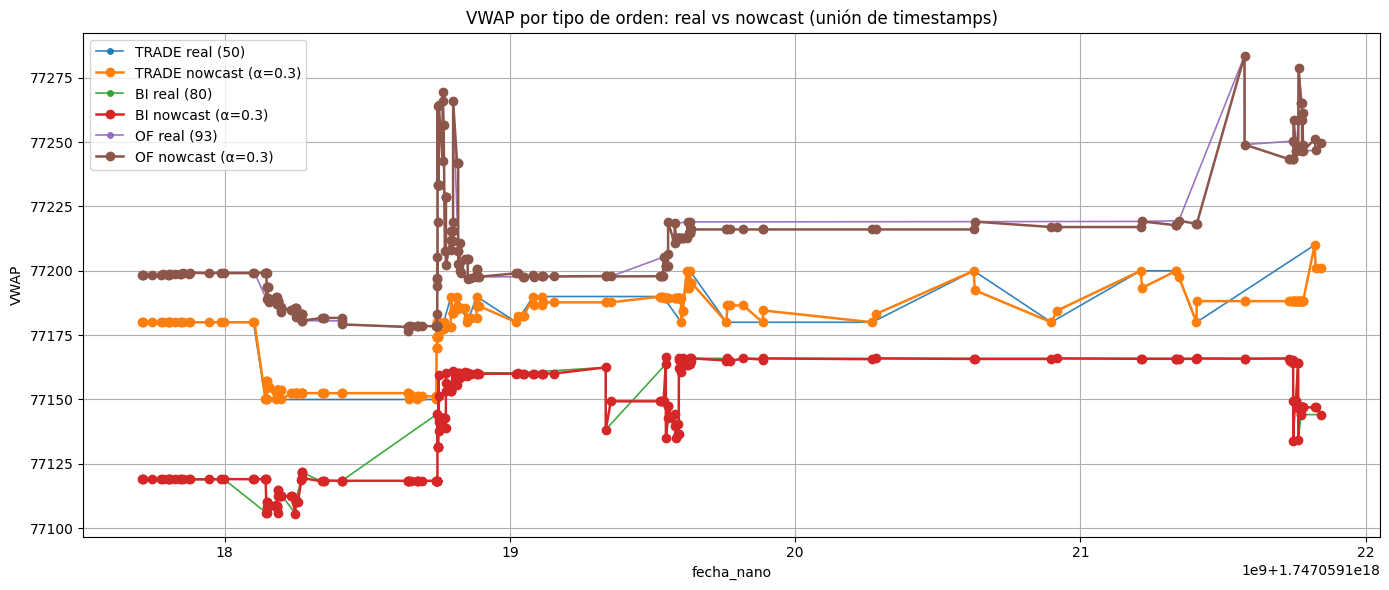

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

alpha = 0.3
sides = [s for s in ["TRADE","BI","OF"] if s in series_by_side]

# unión de timestamps (VWAP) de todos los sides
t_union = sorted(set().union(*[set(series_by_side[s]["vwap"].sort_index().index) for s in sides]))

# panel de nowcasts en todos los timestamps de la unión
rows = [ewma_nowcast_row(series_by_side, t, alpha=alpha) for t in t_union]
panel_nowcast = pd.concat(rows).sort_index()

# plot: 3 sides x (original + nowcast) = 6 series
plt.figure(figsize=(14,6))

for side in sides:
    n = len(series_by_side[side]["vwap"])
    # original (puntos y línea fina)
    plt.plot(series_by_side[side]["vwap"].sort_index(),
             marker='o', markersize=4, linewidth=1.2, alpha=0.9,
             label=f"{side} real ({n})")
    # nowcast (línea punteada sobre la grilla común)
    col = f"{side}_vwap"
    if col in panel_nowcast.columns:
        plt.plot(panel_nowcast.index, panel_nowcast[col], '-o', linewidth=1.8,
                 label=f"{side} nowcast (α={alpha})")

plt.title("VWAP por tipo de orden: real vs nowcast (unión de timestamps)")
plt.xlabel("fecha_nano")
plt.ylabel("VWAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [70]:
import numpy as np
import pandas as pd

alpha = 0.3
sides = [s for s in ["TRADE","BI","OF"] if s in series_by_side]
cols = [c for c in ["vwap","spread"] if all(c in series_by_side[s] for s in sides)]

t_union = sorted(set().union(*[set(series_by_side[s][cols[0]].sort_index().index) for s in sides]))
rows = [ewma_nowcast_row(series_by_side, t, alpha=alpha) for t in t_union]
panel_nowcast = pd.concat(rows).sort_index()

colnames = [f"{s}_{c}" for s in sides for c in cols]
values_df = panel_nowcast[colnames].copy()

is_real_df = pd.DataFrame(False, index=values_df.index, columns=values_df.columns)
for s in sides:
    for c in cols:
        col = f"{s}_{c}"
        idx_real = series_by_side[s][c].sort_index().index
        is_real_df[col] = values_df.index.isin(idx_real)

values_df.head(), is_real_df.head()


(                     TRADE_vwap  TRADE_spread       BI_vwap  BI_spread  \
 1747059117710992687     77180.0           0.0  77119.021940  20.417003   
 1747059117713828118     77180.0           0.0  77119.021940  20.417003   
 1747059117713987140     77180.0           0.0  77119.021940  20.417003   
 1747059117746052884     77180.0           0.0  77118.964492  21.006636   
 1747059117776755801     77180.0           0.0  77118.992641  20.717716   
 
                           OF_vwap  OF_spread  
 1747059117710992687  77198.437034  18.857808  
 1747059117713828118  77198.437034  18.857808  
 1747059117713987140  77198.437034  18.857808  
 1747059117746052884  77198.437034  18.857808  
 1747059117776755801  77198.437034  18.857808  ,
                      TRADE_vwap  TRADE_spread  BI_vwap  BI_spread  OF_vwap  \
 1747059117710992687        True          True    False      False    False   
 1747059117713828118       False         False     True       True    False   
 1747059117713987140  

In [71]:
len(values_df)

223